In [63]:
"""
array based approach is not scalable; matrix grows exponentially with context length
going from bigram to MLP to predict next character (following Bengio et al: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
-> reserach paper made word level model, but well stick to characters
-> for every word in vocab (17,000), a 30-dim feature vector
-> very crowded
-> these embeddings are init randomly, but are tuned using backprop
-> max log liklihood of training data
-> "out of distributiuon": youre in inference time and you see an exmaple that you haven't encountered in training time
-> embeddings approach, lets you get around "out of distribution" problem
----> A and the are interchangeable, embeddings are nearby for a and the, transfer knowledge through embeddings
-> hyperparameter-> design choice for the neural network, up to neural network designer
-> 

"""

'\narray based approach is not scalable; matrix grows exponentially with context length\ngoing from bigram to MLP to predict next character (following Bengio et al: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)\n-> reserach paper made word level model, but well stick to characters\n-> for every word in vocab (17,000), a 30-dim feature vector\n-> very crowded\n-> these embeddings are init randomly, but are tuned using backprop\n-> max log liklihood of training data\n-> "out of distributiuon": youre in inference time and you see an exmaple that you haven\'t encountered in training time\n-> embeddings approach, lets you get around "out of distribution" problem\n----> A and the are interchangeable, embeddings are nearby for a and the, transfer knowledge through embeddings\n-> hyperparameter-> design choice for the neural network, up to neural network designer\n-> \n\n'

In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [65]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [66]:
len(words)


32033

In [67]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [68]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [69]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [70]:
# create the embeddings space
# paper has 17K words, we only have 27 characters
# lets make embedding space 2 dimensional
C = torch.randn((27, 2))

In [71]:
#embed one word
C[5]

tensor([-0.4998,  0.3961])

In [72]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4998,  0.3961])

In [73]:
# we can interpret the embeddings as a layer, a layer with no non linearity, whose parameters are the matrix C
# for now we will index into C, because it is faster

In [74]:
C[[1, 2, 3]]

tensor([[ 0.9502, -0.4485],
        [-0.7982,  0.5253],
        [-0.8011,  2.5952]])

In [75]:
emb = C[X] # pytorch indexing is amazing

In [76]:
emb.shape # we want 32 * 6 shape

torch.Size([32, 3, 2])

In [77]:
W1 = torch.randn((6, 100))
b1 = torch.rand(100)

In [78]:
# we want to do emb @ W1 + b1
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075, -0.4998,  0.3961],
        [-1.3702,  0.9075, -0.4998,  0.3961, -0.4761,  2.0225],
        [-0.4998,  0.3961, -0.4761,  2.0225, -0.4761,  2.0225],
        [-0.4761,  2.0225, -0.4761,  2.0225,  0.9502, -0.4485],
        [-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075,  0.5976, -0.3545],
        [-1.3702,  0.9075,  0.5976, -0.3545,  0.1793,  0.2570],
        [ 0.5976, -0.3545,  0.1793,  0.2570,  2.3497, -2.0078],
        [ 0.1793,  0.2570,  2.3497, -2.0078,  1.3155, -0.6029],
        [ 2.3497, -2.0078,  1.3155, -0.6029,  2.3497, -2.0078],
        [ 1.3155, -0.6029,  2.3497, -2.0078,  0.9502, -0.4485],
        [-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075,  0.9502, -0.4485],
        [-1.3702,  0.9075,  0.9502, -0.4485,  1.3155, -0.6029],
        [ 0.9502, -0.4485,  1.3155, -0.6

In [79]:
# more efficient way... torch.view(), storage is identical, the attributed are being manipulated
# more for torch internals: 
#---> https://blog.ezyang.com/2019/05/pytorch-internals/
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [80]:
a.shape

torch.Size([18])

In [81]:
a.view(3, 6)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])

In [82]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [83]:
emb.shape # we want 32 * 6 shape

torch.Size([32, 3, 2])

In [84]:
emb.view(32, 6)

tensor([[-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075, -0.4998,  0.3961],
        [-1.3702,  0.9075, -0.4998,  0.3961, -0.4761,  2.0225],
        [-0.4998,  0.3961, -0.4761,  2.0225, -0.4761,  2.0225],
        [-0.4761,  2.0225, -0.4761,  2.0225,  0.9502, -0.4485],
        [-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075,  0.5976, -0.3545],
        [-1.3702,  0.9075,  0.5976, -0.3545,  0.1793,  0.2570],
        [ 0.5976, -0.3545,  0.1793,  0.2570,  2.3497, -2.0078],
        [ 0.1793,  0.2570,  2.3497, -2.0078,  1.3155, -0.6029],
        [ 2.3497, -2.0078,  1.3155, -0.6029,  2.3497, -2.0078],
        [ 1.3155, -0.6029,  2.3497, -2.0078,  0.9502, -0.4485],
        [-1.3702,  0.9075, -1.3702,  0.9075, -1.3702,  0.9075],
        [-1.3702,  0.9075, -1.3702,  0.9075,  0.9502, -0.4485],
        [-1.3702,  0.9075,  0.9502, -0.4485,  1.3155, -0.6029],
        [ 0.9502, -0.4485,  1.3155, -0.6

In [85]:
# more organized:

In [86]:
emb = C[X] # pytorch indexing is amazing

In [87]:
W1 = torch.randn((6, 100))
b1 = torch.rand(100)

In [88]:
# cat creates new memory, .view is way more efficient
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # first element of view() is -1, pytorch will infer the size
h

tensor([[-0.5949,  0.8825, -0.9991,  ...,  0.2154, -0.9603, -0.9995],
        [-0.8762,  0.9761, -0.9332,  ...,  0.3455, -0.9242, -0.9972],
        [-0.9981, -0.9989, -0.9586,  ...,  0.7263, -0.9985, -0.9629],
        ...,
        [ 1.0000,  0.9777, -0.5695,  ..., -0.5574,  0.9966,  0.5221],
        [ 0.8508,  0.9813,  0.9997,  ...,  0.6148,  0.9960,  0.7054],
        [ 0.2092, -0.9902,  0.9964,  ...,  0.2392,  0.9068,  0.9822]])

In [89]:
h.shape

torch.Size([32, 100])

In [90]:
W2 = torch.randn((100, 27))
b2 = torch.rand(27)

In [91]:
logits = h @ W2 + b2 


In [92]:
counts = logits.exp() # get fake counts


In [93]:
"""
shape of counts: 32, 27
counts/sum():    32, 1 -> each of the 27 elements in the row will get the same thing to divide by elementwise
"""
prob = counts / counts.sum(1, keepdims=True) # sum along first dim (we want to end up with 32 sums, not 27)

In [94]:
prob.shape

torch.Size([32, 27])

In [95]:
# now we have the probs as predicted by our neural net -> lets pick out the probs assigned by
# the neural net to the expected next token (which are given by Y)
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [96]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7983)

In [97]:
# much more respectable

In [98]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)


In [99]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [100]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [101]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [102]:
for p in parameters:
    p.requires_grad = True

In [103]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [104]:
# we shouldnt run the forward and backward on the entire dataset, 
# instead we should run these on mini-batches of the dataset
# lri = []
# lossi = []
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, )) # using gradient of 32 random datapoints
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp() # get fake counts
    # prob = counts / counts.sum(1, keepdims=True) # sum along first dim (we want to end up with 32 sums, not 27)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # 1) fused kernels, equivalent to above, 2) backward pass is simpler 
                                        # 3) numerically well behaved (with the exp, doesn't work well with very positive nums)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # zeros out the grad
    loss.backward()
    
    # update parameters data
    # lr = lrs[i]
    lr = 0.05
    for p in parameters: # 0.001 - 1
        p.data += -lr * p.grad # how do you determine learning rate? guess and check with a low and high range of learning rates

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

KeyboardInterrupt: 

In [ ]:
# learning rate plot
plt.plot(lri, lossi)

In [ ]:
# how well is the model doing on the whole dataset:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
torch.randint(0, X.shape[0], (32, ))

In [ ]:
# why is loss not 0? because same prefix of 3 characters can lead to multiple outcomes
logits.max(1)

In [ ]:
Y

In [ ]:
"""
We have a better model with lower loss?
as model grows, the more capable it is to overfit the training data
its just memorizing the training set, dont get new data

standard in the field:
training split, validation/dev split, test split (80%, 10%, 10%)

traing - optimize params
dev - devlopment over hyperparams
test - eval the performance of the model at the end, very sparingly otherwise 
                you are leaking information from the test split as well
"""

In [ ]:
# lets put this into practice

In [187]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [188]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype


(torch.Size([182437, 3]), torch.int64, torch.Size([182437]), torch.int64)

In [189]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [190]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [191]:
for p in parameters:
    p.requires_grad = True

In [208]:
# we shouldnt run the forward and backward on the entire dataset, 
# instead we should run these on mini-batches of the dataset
# lri = []
# lossi = []
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, )) # using gradient of 32 random datapoints
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp() # get fake counts
    # prob = counts / counts.sum(1, keepdims=True) # sum along first dim (we want to end up with 32 sums, not 27)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # 1) fused kernels, equivalent to above, 2) backward pass is simpler 
                                        # 3) numerically well behaved (with the exp, doesn't work well with very positive nums)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # zeros out the grad
    loss.backward()
    
    # update parameters data
    # lr = lrs[i]
    lr = 0.01
    for p in parameters: # 0.001 - 1
        p.data += -lr * p.grad # how do you determine learning rate? guess and check with a low and high range of learning rates

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

2.5190606117248535


In [209]:
# how well is the model doing on the whole dataset:
# training and test are equal - "underfitting"
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3005, grad_fn=<NllLossBackward0>)

In [210]:
# how well is the model doing on the whole dataset:
# training and test are equal - "underfitting"
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3174, grad_fn=<NllLossBackward0>)

In [ ]:
# learning rate plot
plt.plot(lri, lossi)

In [ ]:
# scale the neural network up:

In [211]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [212]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype


(torch.Size([182441, 3]), torch.int64, torch.Size([182441]), torch.int64)

In [213]:
# increased the hidden layer size from 100 to 300, and make the embeddings dim from 2 to 10
# and decrease hidden layer to 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [214]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [215]:
for p in parameters:
    p.requires_grad = True

In [216]:
lri = []
lossi = []
stepi = []


In [218]:
# we shouldnt run the forward and backward on the entire dataset, 
# instead we should run these on mini-batches of the dataset
for i in range(50_000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, )) # using gradient of 32 random datapoints
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # 1) fused kernels, equivalent to above, 2) backward pass is simpler 
                                        # 3) numerically well behaved (with the exp, doesn't work well with very positive nums)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # zeros out the grad
    loss.backward()
    
    # update parameters data
    # lr = lrs[i]
    lr = 0.01
    for p in parameters: # 0.001 - 1
        p.data += -lr * p.grad # how do you determine learning rate? guess and check with a low and high range of learning rates

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.334859609603882


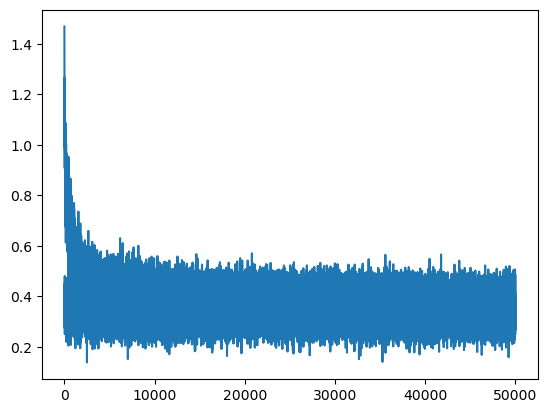

In [183]:
plt.plot(stepi, lossi)

In [219]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1647, grad_fn=<NllLossBackward0>)

In [220]:
# how well is the model doing on the whole dataset:
# training and test are equal - "underfitting", we can make the model better...
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2020, grad_fn=<NllLossBackward0>)

In [ ]:
# when training loss and dev loss starts to diverse, nn is large enough and we may be overfitting
# what are some knobs we can tweak to surpass validation loss?:
# 1) hidden layer size 2) dim of embeddings 3) number of input characters context 4) details of optimization, 
# e.g. how long are we running, what is the learning rate, how does it change over time, mini batch size

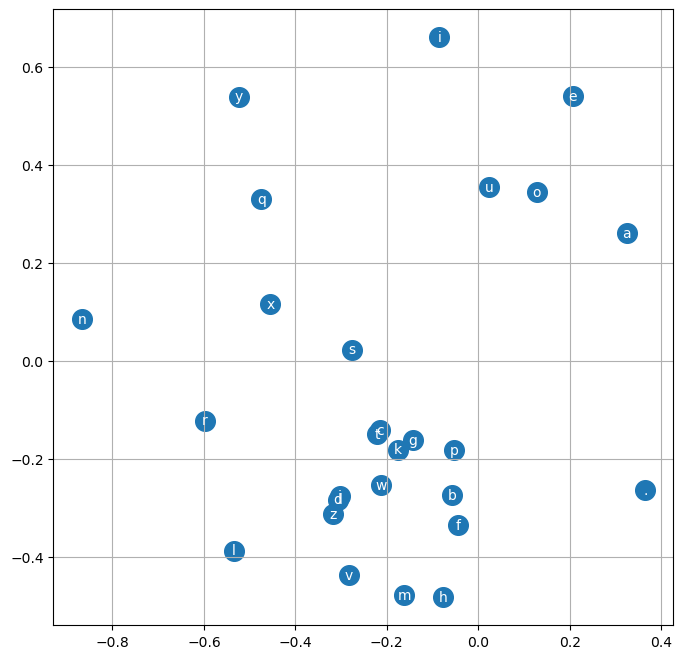

In [175]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [186]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


carmahfa.
jehleigh.
mili.
tholdence.
saeja.
hubedamerynt.
kaeli.
nellara.
chaiivon.
leggy.
ham.
por.
desian.
sulie.
alian.
quintthoniearyxi.
jacee.
dusabee.
depo.
abetteley.
